# iPython Notebook Sample
### Jukka Ruponen, IBM, 2015-11-18

#### Hypothesis: "In order to earn more tips, taxi drivers should favor carrying more people at once"

In order to confirm the hypothesis, this notebook will do the following:
    1) Read NYC taxidata from Open API
    2) Normalize and test the data & analysis
    3) Export the analysis result (as CSV file) into HDFS in "Analytics for Apache Hadoop" service for further processing
    4) Visualize the result to confirm (or reject) our hypothesis

### Add the required modules

In [1]:
import pandas
import requests
import json

### Read NYC taxidata from REST API

In [2]:
raw_taxidata = requests.get('https://data.cityofnewyork.us/resource/2yzn-sicd.json')
json_taxidata = raw_taxidata.json()

In [4]:
# (Optional) Print out the data - Do not run this step, unless you really want to see lots of data !!
json_taxidata

[{u'dropoff_latitude': u'40.743377685546875',
  u'dropoff_longitude': u'-73.973762512207031',
  u'extra': u'0.5',
  u'fare_amount': u'7.5',
  u'mta_tax': u'0.5',
  u'passenger_count': u'1',
  u'payment_type': u'2',
  u'pickup_latitude': u'40.724250793457031',
  u'pickup_longitude': u'-73.987686157226562',
  u'ratecodeid': u'1',
  u'store_and_fwd_flag': u'N',
  u'tip_amount': u'0',
  u'tolls_amount': u'0',
  u'total_amount': u'8.8',
  u'tpep_dropoff_datetime': u'2015-01-08T22:50:56.000',
  u'tpep_pickup_datetime': u'2015-01-08T22:44:09.000',
  u'trip_distance': u'1.55',
  u'vendorid': u'2'},
 {u'dropoff_latitude': u'40.721080780029297',
  u'dropoff_longitude': u'-74.004104614257813',
  u'extra': u'0.5',
  u'fare_amount': u'7',
  u'mta_tax': u'0.5',
  u'passenger_count': u'3',
  u'payment_type': u'2',
  u'pickup_latitude': u'40.726932525634766',
  u'pickup_longitude': u'-73.991569519042969',
  u'ratecodeid': u'1',
  u'store_and_fwd_flag': u'N',
  u'tip_amount': u'0',
  u'tolls_amount': u

In [3]:
# What is the lenght of data (number of lines)?
print len(json_taxidata)

1000


### Lets normalize and test the data, and try to find an answer

In [5]:
# Lets import json_normalize since we can use it to convert JSON data to tabular data
from pandas.io.json import json_normalize

In [6]:
# Make a normalized data frame and print out the first five rows
taxidata = json_normalize(json_taxidata)
taxidata.head()

,dropoff_latitude,dropoff_longitude,extra,fare_amount,mta_tax,passenger_count,payment_type,pickup_latitude,pickup_longitude,ratecodeid,store_and_fwd_flag,tip_amount,tolls_amount,total_amount,tpep_dropoff_datetime,tpep_pickup_datetime,trip_distance,vendorid
0,40.743377685546875,-73.973762512207031,0.5,7.5,0.5,1,2,40.724250793457031,-73.987686157226562,1,N,0,0,8.8,2015-01-08T22:50:56.000,2015-01-08T22:44:09.000,1.55,2
1,40.721080780029297,-74.004104614257813,0.5,7,0.5,3,2,40.726932525634766,-73.991569519042969,1,N,0,0,8.3,2015-01-08T22:51:17.000,2015-01-08T22:44:09.000,1.20,1
2,40.798198699951172,-73.952354431152344,0.5,10.5,0.5,1,2,40.783443450927734,-73.981918334960938,1,N,0,0,11.8,2015-01-08T22:55:27.000,2015-01-08T22:44:10.000,2.40,1
3,40.832000732421875,-73.919570922851563,0.5,21.5,0.5,1,2,40.743553161621094,-73.973121643066406,1,N,0,0,22.8,2015-01-08T22:58:09.000,2015-01-08T22:44:10.000,7.30,1
4,40.764053344726562,-73.984390258789063,0.5,3.5,0.5,1,2,40.766208648681641,-73.982948303222656,1,N,0,0,4.8,2015-01-08T22:46:16.000,2015-01-08T22:44:12.000,0.40,1


In [7]:
# Since the numeric values are actually text strings, we'll first need to convert them to float
taxidata2 = taxidata.convert_objects(convert_numeric=True)

In [8]:
# Test: What is the biggest amount of fare paid?
taxidata2['fare_amount'].max()

75.0

In [9]:
# Test: What is the biggest amount of tip paid?
taxidata2['tip_amount'].max()

20.0

### (Optional) Store raw data on the local GPFS and the Object Store

In [45]:
# Save the raw data as CSV file on the local GPFS file system
taxidata2.to_csv('nyc_taxidata.csv', index=False)
# Just to confirm it was saved, print out the first 4 lines of the saved file
!head -n4 'nyc_taxidata.csv'

dropoff_latitude,extra,mta_tax,passenger_count,payment_type,pickup_latitude,pickup_longitude,ratecodeid,store_and_fwd_flag,tip_amount,tolls_amount,total_amount,tpep_dropoff_datetime,tpep_pickup_datetime,trip_distance,vendorid
40.74607849121094,1.0,0.5,1,2,40.71593856811523,-74.00713348388672,1,N,0.0,0.0,17.3,2015-05-29T16:28:38.000,2015-05-29T16:05:47.000,2.28,2
40.81212997436523,0.0,0.5,1,2,40.77290725708008,-73.95793151855469,1,N,0.0,0.0,14.8,2015-04-12T14:01:10.000,2015-04-12T13:45:02.000,3.5,1
40.75371170043945,0.0,0.5,1,1,40.76110076904297,-73.97488403320312,1,N,1.0,0.0,7.3,2015-01-23T09:51:59.000,2015-01-23T09:46:23.000,0.5,1


In [47]:
# Uploading the raw data file from GPFS to Object Store will be done using curl.
# Before that you'll first need to acquire your specific storage <URL> and <Token>.
# Modify the command below so that "user.id" contains your object store's userId, "user.password" contains the password and "scope.project.id" contains the projectId value.
!curl -i -H "Content-Type: application/json" -d '{"auth": {"identity": {"methods": ["password"],"password": {"user": {"id": "<userId>", "password": "<password>"}}},"scope": {"project": {"id": "0d742b7e4584410a9378f60f6eb34514"}}}}' https://identity.open.softlayer.com/v3/auth/tokens ; echo

# After run, pick up the values
# 1) "X-Subject-Token" value in the response header is your <Token>
# 2) Your projectId -specific storage <URL> is where the "region_id" corresponds to your region and "interface" is "internal"
#   (the URL you need should start as "https://dal.objectstorage.service.open.networklayer.com/v1/AUTH_...")










{"token": {"methods": ["password"], "roles": [{"id": "f61f06a84f6443e880210fa986bd8691", "name": "ObjectStorageOperator"}], "expires_at": "2015-12-02T23:20:36.466193Z", "project": {"domain": {"id": "d0073e29567b415bbe8198eca77e8c57", "name": "791473"}, "id": "0d742b7e4584410a9378f60f6eb34514", "name": "object_storage_317aecff"}, "catalog": [{"endpoints": [{"region_id": "london", "url": "https://lon-api.open.softlayer.com:8776/v2/0d742b7e4584410a9378f60f6eb34514", "region": "london", "interface": "admin", "id": "3483bd54388545d6a1dd1c675ee93a41"}, {"region_id": "london", "url": "https://lon-api.open.softlayer.com:8776/v2/0d742b7e4584410a9378f60f6eb34514", "region": "london", "interface": "internal", "id": "86e3ee81d05c41ea8fa1c69e0d0e0331"}, {"region_id": "sydney", "url": "https://syd-api.open.softlayer.com:8776/v2/0d742b7e4584410a9378f60f6eb34514", "region": "sydney", "interface": "public", "id": "9762e98582d340a09d3d1c442cd18060"}, {"region_id": "sydney", "url": "https://syd-

In [48]:
# After run the previous task, modify the curl command on below to upload the file from local GPFS to the Object Store
# Command syntax is:
# !curl -i <URL>/<container>/<filename> -X PUT -H "X-Auth-Token:<Token>" -T <filename on local GPFS>
!curl -i https://dal.objectstorage.service.open.networklayer.com/v1/AUTH_0d742b7e4584410a9378f60f6eb34514/tests/nyc_taxidata.csv -X PUT -H "X-Auth-Token:gAAAAABWX2607pNXjXvlXzK-FDkw60v_N919K4-hHgWEUBmQg8X5cDqm8SwsJt6TbSoHvuM1ohiEuH8MqkYL7mf917sQ0DrbEUPnsUqbRmoP7ldtS1UO-T-B2THPV_V5ep0Zd2iRYuNz2oJ7ELJ9hXQl2oGjc_m-XaUxRfpFCeY9lS4a11uoYGM%3D" -T nyc_taxidata.csv

HTTP/1.1 100 Continue

HTTP/1.1 201 Created
Last-Modified: Wed, 02 Dec 2015 22:21:19 GMT
Content-Length: 0
Etag: f213363488121269ff709e9296e932b6
Content-Type: text/html; charset=UTF-8
X-Trans-Id: txeaefc9c71eae48e692f58-00565f6ede
Date: Wed, 02 Dec 2015 22:21:18 GMT



### Continuing analysis

In [10]:
# Test: How many individual taxi trips with different number of passengers?
taxidata2['passenger_count'].value_counts()

1    724
2    147
5     45
3     34
6     27
4     23
dtype: int64

In [11]:
# Just to play around, setting index to vendorid
passengers = taxidata2.set_index(taxidata["vendorid"])
# Drop off unneeded columns to clean the data
passengers.drop(['extra','mta_tax','vendorid','dropoff_latitude','dropoff_longitude','pickup_latitude','pickup_longitude','ratecodeid','store_and_fwd_flag'], axis=1, inplace=True)
passengers.head()

,fare_amount,passenger_count,payment_type,tip_amount,tolls_amount,total_amount,tpep_dropoff_datetime,tpep_pickup_datetime,trip_distance
vendorid,,,,,,,,,
2,7.5,1,2,0,0,8.8,2015-01-08T22:50:56.000,2015-01-08T22:44:09.000,1.55
1,7.0,3,2,0,0,8.3,2015-01-08T22:51:17.000,2015-01-08T22:44:09.000,1.20
1,10.5,1,2,0,0,11.8,2015-01-08T22:55:27.000,2015-01-08T22:44:10.000,2.40
1,21.5,1,2,0,0,22.8,2015-01-08T22:58:09.000,2015-01-08T22:44:10.000,7.30
1,3.5,1,2,0,0,4.8,2015-01-08T22:46:16.000,2015-01-08T22:44:12.000,0.40


In [12]:
# Test: How much tips were given total by the number of passangers in the taxi?
passengers.groupby('passenger_count')['tip_amount'].sum()

passenger_count
1                  1193.24
2                   291.63
3                    48.73
4                    32.49
5                    54.23
6                    52.61
Name: tip_amount, dtype: float64

In [13]:
# Got it! So group the data by passenger_count and extract average stats for each 'number of passengers' group
averages = passengers.groupby(['passenger_count']).agg({'fare_amount': 'mean',
                                             'tip_amount': 'mean',
                                             'trip_distance': 'mean'})
averages

,trip_distance,tip_amount,fare_amount
passenger_count,,,
1,2.977680,1.648122,12.890470
2,3.183061,1.983878,13.197279
3,2.577941,1.433235,11.955882
4,2.092609,1.412609,9.978261
5,2.672889,1.205111,11.800000
6,3.387778,1.948519,14.203704


### (Optional) Save the results from previous output in a CSV file on the local GPFS and then upload it to your HDFS (Analytics for Apache Hadoop)

In [13]:
# Save the last result as CSV file on the local GPFS filesystem (just to make it clear: It's NOT saved in the "Object Store")
_.to_csv('test.csv')

# Just to confirm it was saved, print out the first 4 lines of the saved file
!head -n4 'test.csv'

passenger_count,trip_distance,tip_amount,fare_amount
1,3.1659361997226068,1.6951733703190002,13.166851595006934
2,3.353777777777774,1.9487407407407402,13.433333333333334
3,3.05825,1.5355,12.7625


In [15]:
# Using curl, upload the file into HDFS of our Analytics for Apache Hadoop service
# Note: You can find the right settings from Environment Variables / VCAP_SERVICES for the application where your Hadoop service is bound with
HDFS_WebhdfsUrl = "https://bi-hadoop-prod-2470.services.dal.bluemix.net:8443/gateway/default/webhdfs/v1" # Replace with your WebhdfsUrl
HDFS_userid = "biblumix" # Hadoop user's userid
HDFS_password = "<password>" # Replace <password> with your Hadoop user's password
Local_filename = "test.csv" # This is the local filename you used with the _.to_csv('filename') command above
HDFS_filepath = "/user/biblumix/test/test.csv" # This is the filename to be stored, with full path on HDFS (the directory will be created, if not exist)
HDFS_operator = "op=CREATE" # 'op=CREATE' will create a new file. For other operators, see: https://hadoop.apache.org/docs/r1.0.4/webhdfs.html
HDFS_maxTime = 45 # This is seconds after which the transfer will timeout, success or not. Make sure its long enough for full transfer.
!curl -i -L -k -s --user "$HDFS_userid":"$HDFS_password" --max-time $HDFS_maxTime -X PUT -T "$Local_filename" "$HDFS_WebhdfsUrl$HDFS_filepath?$HDFS_operator"

HTTP/1.1 307 Temporary Redirect
Set-Cookie: JSESSIONID=16u877cxo34m51a36u6f0pg7rk;Path=/gateway/default;Secure;HttpOnly
Expires: Thu, 01 Jan 1970 00:00:00 GMT
Cache-Control: no-cache
Expires: Wed, 18 Nov 2015 22:39:20 GMT
Date: Wed, 18 Nov 2015 22:39:20 GMT
Pragma: no-cache
Expires: Wed, 18 Nov 2015 22:39:20 GMT
Date: Wed, 18 Nov 2015 22:39:20 GMT
Pragma: no-cache
Location: https://bi-hadoop-prod-2470.services.dal.bluemix.net:8443/gateway/default/webhdfs/data/v1/webhdfs/v1/user/biblumix/test/test.csv?_=AAAACAAAABAAAACgWTMYkroZaYjPf4hTLFsqvqcCRj84oRcgTSz7fIhbTclST6K0TBpyzd96OQe3M1MB7xhYEg5F2pIMj0u_lF_zJDFGex0SxNbwoxl-jxDoq8IWTkcCUZcZZls_K2cppwOpjXbjLGYs78Xku_3AGXjQbZn3mRmeREWzl8vVzDt6QkAwdg7j-5h-U7rb7xQCM-2i4_q72pPasqM8z2JudF83pzoRnNWFGhFXdgduPuFdCGTiOgNoOKIpBw
Server: Jetty(6.1.26-ibm)
Content-Type: application/octet-stream
Connection: close

HTTP/1.1 100 Continue

HTTP/1.1 403 Forbidden
Set-Cookie: JSESSIONID=1q0mc0lxc7ugfs70s3cd33bd1;Path=/gateway/default;Secure;HttpOnly
Expires: Thu

### Lets visualize the answer

In [14]:
%matplotlib inline

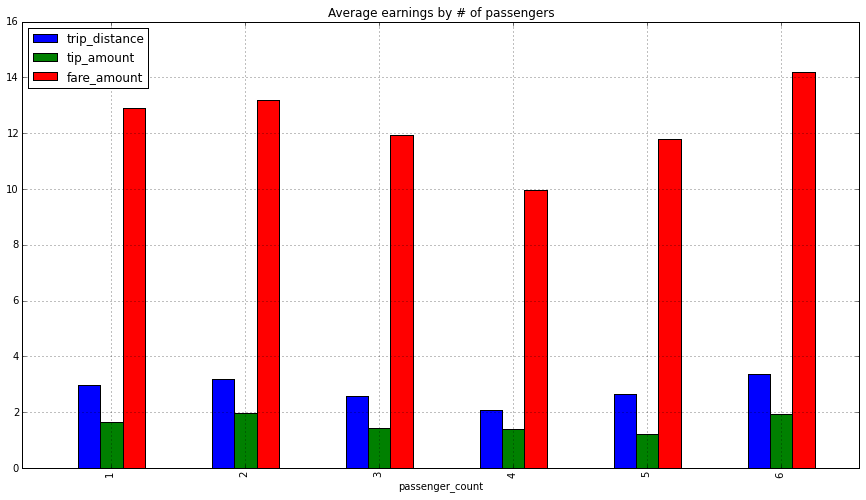

In [15]:
#passengers = averages.ix['passenger_count']
averages.plot(kind='bar', figsize=(15,8), title="Average earnings by # of passengers" % passengers)

In [37]:
!curl -i https://dal.objectstorage.service.open.networklayer.com/v1/AUTH_0d742b7e4584410a9378f60f6eb34514/tests/test.csv -X PUT -H "X-Auth-Token:<auth-token>" -T test.csv

HTTP/1.1 100 Continue

HTTP/1.1 201 Created
Last-Modified: Wed, 02 Dec 2015 21:20:42 GMT
Content-Length: 0
Etag: f6b14972fc3bd6ba88b88ff928253c3a
Content-Type: text/html; charset=UTF-8
X-Trans-Id: tx0e97103b796a4c1289a12-00565f60a9
Date: Wed, 02 Dec 2015 21:20:41 GMT

